Solving with MILP...
Solving with Greedy...

Visualization saved as 'gate_allocation_results.png'

MILP Optimal Cost: 21987.86
Greedy Cost: 22383.89
Greedy Optimality: 98.2%
Greedy Gap: 1.8%


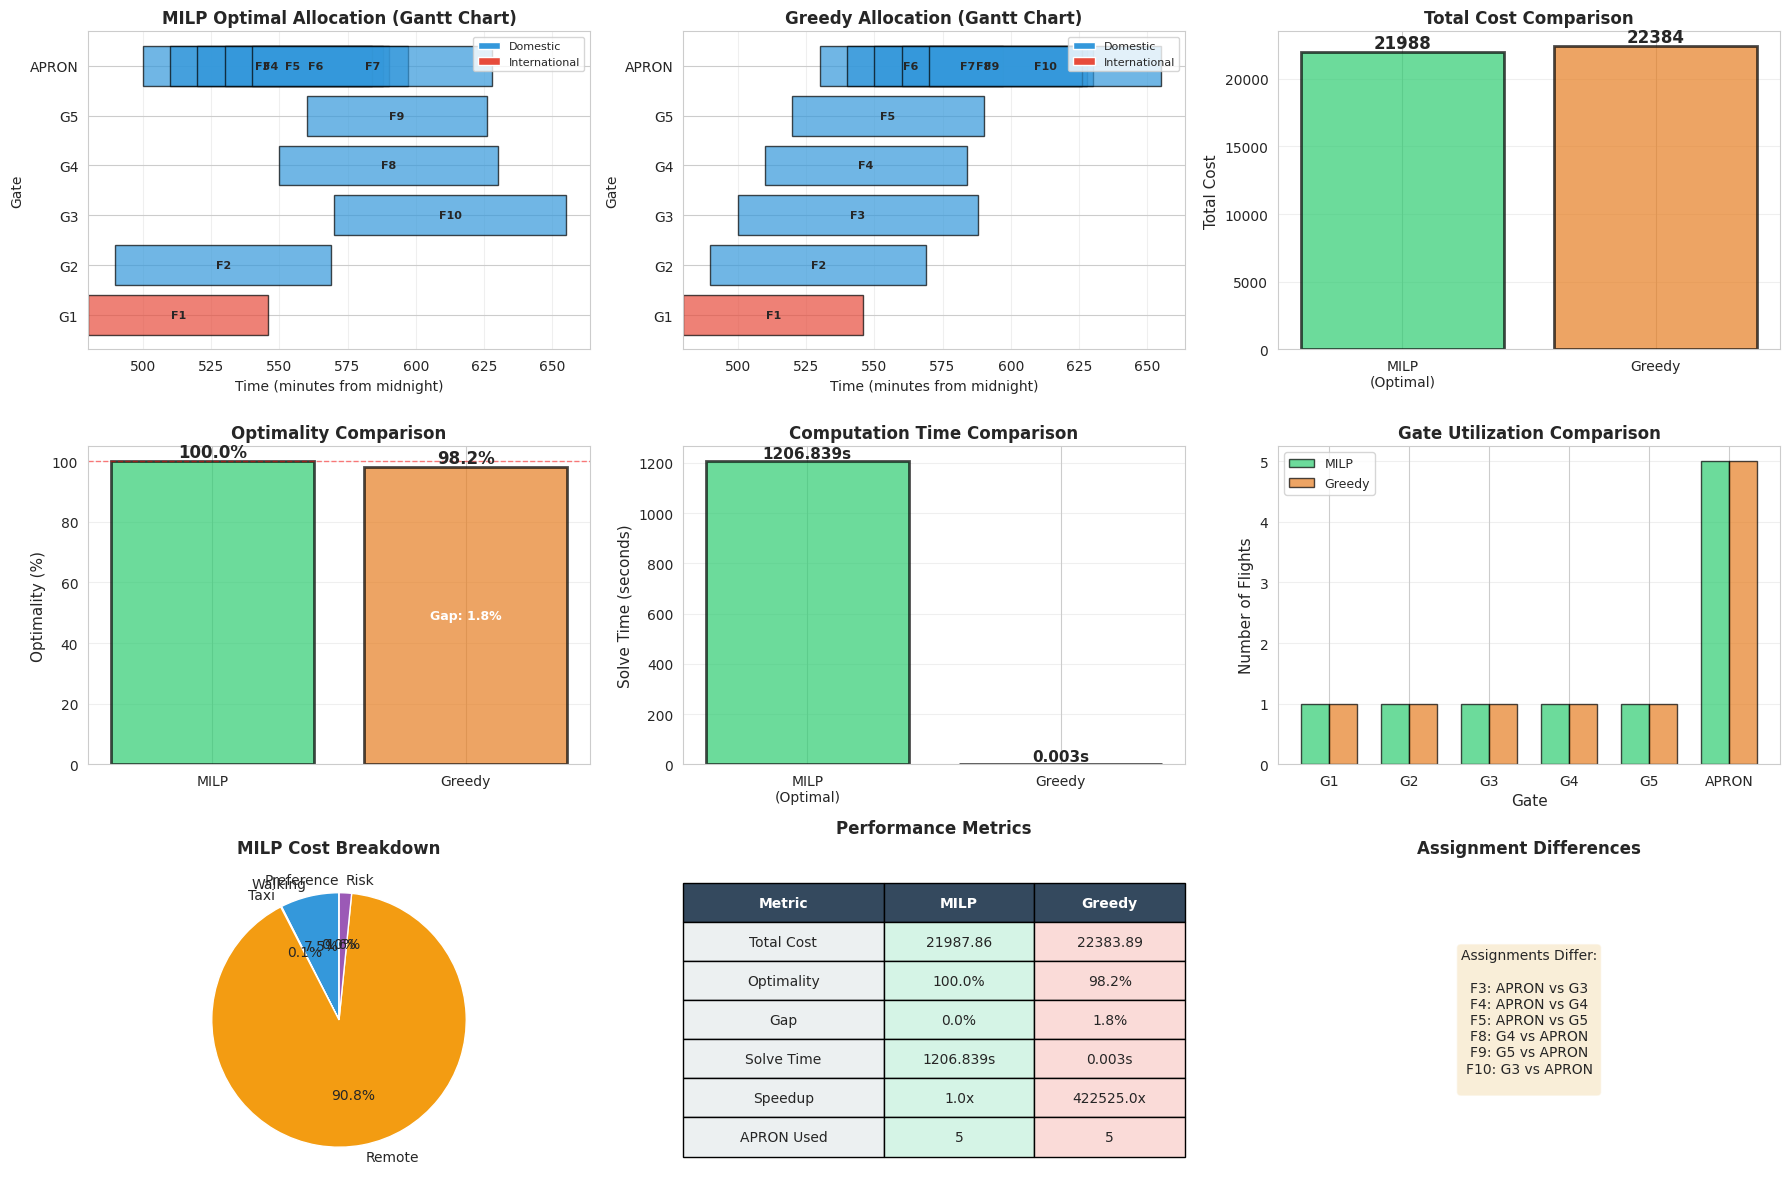

In [ ]:
import pulp as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import time

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# --- PARAMETERS AND DATA SETUP ---
W_ALPHA, T_BETA, R_GAMMA, K_DELTA, P_RHO = 1.0, 0.5, 0.8, 0.6, 0.2
B_EPSILON = 0.3
BUFFER_TIME = 15
SWING_BUFFER = 45
MIN_TURNAROUND_TIME = 60
APRON_PENALTY_R = 5000

def initialize_data(num_flights=10, num_gates=5):
    np.random.seed(42)

    gates_data = {
        'GateID': [f'G{i+1}' for i in range(num_gates)],
        'Location_Metric': [1.0, 1.2, 1.5, 2.0, 2.5],
        'Swing': [1, 1, 0, 0, 1],
        'FixMode': ['INTL', 'None', 'DOM', 'DOM', 'None'],
    }
    gates_df = pd.DataFrame(gates_data).set_index('GateID')
    GATES = list(gates_df.index)

    arrival_times = [480 + 10 * i for i in range(num_flights)]
    departure_times = [t + np.random.randint(60, 90) for t in arrival_times]

    flights_df = pd.DataFrame({
        'FlightID': [f'F{i+1}' for i in range(num_flights)],
        'Arrival_Time': arrival_times,
        'Departure_Time': departure_times,
        'Passenger_Count': np.random.randint(150, 300, num_flights),
        'Mode': np.random.choice(['DOM', 'INTL'], num_flights, p=[0.7, 0.3]),
        'Taxi_Time_Proxy': np.random.uniform(5, 15, num_flights)
    })
    flights_df.sort_values(by='Arrival_Time', inplace=True)
    flights_df.set_index('FlightID', inplace=True)
    FLIGHTS = list(flights_df.index)

    flights_df['Effective_Start'] = flights_df['Arrival_Time'] - BUFFER_TIME
    flights_df['Effective_End'] = flights_df['Departure_Time'] + BUFFER_TIME

    CONFLICT_PAIRS = [(i, j) for i in FLIGHTS for j in FLIGHTS if i < j]
    SAME_TAIL_PAIRS = [('F1','F2'), ('F3','F4')]
    ADJACENT_GATES = [('G1', 'G2'), ('G3', 'G4')]
    GATES_EXTENDED = GATES + ['APRON']

    return FLIGHTS, GATES, GATES_EXTENDED, flights_df, gates_df, CONFLICT_PAIRS, SAME_TAIL_PAIRS, ADJACENT_GATES

# --- MILP SOLVER ---
def solve_milp(FLIGHTS, GATES, GATES_EXTENDED, flights_df, gates_df, CONFLICT_PAIRS, SAME_TAIL_PAIRS, ADJACENT_GATES):
    M = 100000
    model = pl.LpProblem("Gate_Allocation", pl.LpMinimize)

    x = pl.LpVariable.dicts("x", (FLIGHTS, GATES_EXTENDED), cat='Binary')
    y = pl.LpVariable.dicts("y", (CONFLICT_PAIRS, GATES), cat='Binary')
    u = pl.LpVariable.dicts("u", (CONFLICT_PAIRS, ADJACENT_GATES), cat='Binary')

    def get_cost(i, g):
        W_ig = flights_df.loc[i, 'Passenger_Count'] * gates_df.loc[g, 'Location_Metric']
        T_ig = flights_df.loc[i, 'Taxi_Time_Proxy'] * (1 + gates_df.loc[g, 'Location_Metric'] * 0.1)
        P_ig = 50 if gates_df.loc[g, 'FixMode'] != 'None' and flights_df.loc[i, 'Mode'] == gates_df.loc[g, 'FixMode'] else 0
        R_ig = 0
        K_ig = 10 * gates_df.loc[g, 'Location_Metric']
        B_ig = 0
        return (W_ALPHA * W_ig + T_BETA * T_ig + R_GAMMA * R_ig + K_DELTA * K_ig + B_EPSILON * B_ig - P_RHO * P_ig)

    objective_terms = []
    for i in FLIGHTS:
        for g in GATES:
            cost_i_g = get_cost(i, g)
            objective_terms.append(cost_i_g * x[i][g])
        cost_i_apron = (R_GAMMA * APRON_PENALTY_R + K_DELTA * 100)
        objective_terms.append(cost_i_apron * x[i]['APRON'])

    model += pl.lpSum(objective_terms), "Total_Cost"

    for i in FLIGHTS:
        model += pl.lpSum(x[i][g] for g in GATES_EXTENDED) == 1, f"C1_{i}"

    for i in FLIGHTS:
        for g in GATES:
            fix_mode = gates_df.loc[g, 'FixMode']
            if fix_mode != 'None' and flights_df.loc[i, 'Mode'] != fix_mode:
                model += x[i][g] == 0, f"C2_{i}_{g}"

    for i, j in CONFLICT_PAIRS:
        t_i_bar = float(flights_df.loc[i, 'Effective_End'])
        t_j_under = float(flights_df.loc[j, 'Effective_Start'])
        t_j_bar = float(flights_df.loc[j, 'Effective_End'])
        t_i_under = float(flights_df.loc[i, 'Effective_Start'])

        for g in GATES:
            xig, xjg, yijg = x[i][g], x[j][g], y[(i, j)][g]
            model += t_i_bar - t_j_under <= M * (1 - yijg) + M * (2 - xig - xjg), f"C4_{i}_{j}_{g}_1"
            model += t_j_bar - t_i_under <= M * yijg + M * (2 - xig - xjg), f"C4_{i}_{j}_{g}_2"

    start_time = time.time()
    model.solve(pl.PULP_CBC_CMD(msg=0))
    solve_time = time.time() - start_time

    allocation = {}
    for i in FLIGHTS:
        for g in GATES_EXTENDED:
            if x[i][g].varValue > 0.5:
                allocation[i] = g
                break

    return allocation, pl.value(model.objective), solve_time

# --- GREEDY HEURISTIC ---
def solve_greedy(FLIGHTS, GATES, flights_df, gates_df):
    def get_cost(i, g):
        W_ig = flights_df.loc[i, 'Passenger_Count'] * gates_df.loc[g, 'Location_Metric']
        T_ig = flights_df.loc[i, 'Taxi_Time_Proxy'] * (1 + gates_df.loc[g, 'Location_Metric'] * 0.1)
        P_ig = 50 if gates_df.loc[g, 'FixMode'] != 'None' and flights_df.loc[i, 'Mode'] == gates_df.loc[g, 'FixMode'] else 0
        K_ig = 10 * gates_df.loc[g, 'Location_Metric']
        return (W_ALPHA * W_ig + T_BETA * T_ig + K_DELTA * K_ig - P_RHO * P_ig)

    def has_conflict(flight, gate, allocation):
        f_start = flights_df.loc[flight, 'Effective_Start']
        f_end = flights_df.loc[flight, 'Effective_End']

        for assigned_flight, assigned_gate in allocation.items():
            if assigned_gate == gate:
                a_start = flights_df.loc[assigned_flight, 'Effective_Start']
                a_end = flights_df.loc[assigned_flight, 'Effective_End']
                if not (f_end <= a_start or a_end <= f_start):
                    return True
        return False

    allocation = {}
    total_cost = 0
    sorted_flights = sorted(FLIGHTS, key=lambda f: flights_df.loc[f, 'Arrival_Time'])

    start_time = time.time()
    for flight in sorted_flights:
        best_gate = None
        best_cost = float('inf')

        for gate in GATES:
            fix_mode = gates_df.loc[gate, 'FixMode']
            if fix_mode != 'None' and flights_df.loc[flight, 'Mode'] != fix_mode:
                continue

            if not has_conflict(flight, gate, allocation):
                cost = get_cost(flight, gate)
                if cost < best_cost:
                    best_cost = cost
                    best_gate = gate

        if best_gate is None:
            best_gate = 'APRON'
            best_cost = R_GAMMA * APRON_PENALTY_R + K_DELTA * 100

        allocation[flight] = best_gate
        total_cost += best_cost

    solve_time = time.time() - start_time
    return allocation, total_cost, solve_time

# --- MAIN EXECUTION ---
FLIGHTS, GATES, GATES_EXTENDED, flights_df, gates_df, CONFLICT_PAIRS, SAME_TAIL_PAIRS, ADJACENT_GATES = initialize_data()

print("Solving with MILP...")
milp_allocation, milp_cost, milp_time = solve_milp(FLIGHTS, GATES, GATES_EXTENDED, flights_df, gates_df,
                                                     CONFLICT_PAIRS, SAME_TAIL_PAIRS, ADJACENT_GATES)

print("Solving with Greedy...")
greedy_allocation, greedy_cost, greedy_time = solve_greedy(FLIGHTS, GATES, flights_df, gates_df)

# --- VISUALIZATIONS ---
fig = plt.figure(figsize=(18, 12))

# --- 1. GANTT CHART COMPARISON ---
ax1 = plt.subplot(3, 3, 1)
y_pos = {g: i for i, g in enumerate(GATES_EXTENDED)}
colors = {'DOM': '#3498db', 'INTL': '#e74c3c'}

for flight in FLIGHTS:
    gate = milp_allocation[flight]
    start = flights_df.loc[flight, 'Arrival_Time']
    duration = flights_df.loc[flight, 'Departure_Time'] - start
    mode = flights_df.loc[flight, 'Mode']

    ax1.barh(y_pos[gate], duration, left=start, height=0.8,
             color=colors[mode], alpha=0.7, edgecolor='black', linewidth=1)
    ax1.text(start + duration/2, y_pos[gate], flight,
             ha='center', va='center', fontsize=8, fontweight='bold')

ax1.set_yticks(list(y_pos.values()))
ax1.set_yticklabels(list(y_pos.keys()))
ax1.set_xlabel('Time (minutes from midnight)', fontsize=10)
ax1.set_ylabel('Gate', fontsize=10)
ax1.set_title('MILP Optimal Allocation (Gantt Chart)', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors['DOM'], label='Domestic'),
                   Patch(facecolor=colors['INTL'], label='International')]
ax1.legend(handles=legend_elements, loc='upper right', fontsize=8)

# --- 2. GREEDY GANTT CHART ---
ax2 = plt.subplot(3, 3, 2)
for flight in FLIGHTS:
    gate = greedy_allocation[flight]
    start = flights_df.loc[flight, 'Arrival_Time']
    duration = flights_df.loc[flight, 'Departure_Time'] - start
    mode = flights_df.loc[flight, 'Mode']

    ax2.barh(y_pos[gate], duration, left=start, height=0.8,
             color=colors[mode], alpha=0.7, edgecolor='black', linewidth=1)
    ax2.text(start + duration/2, y_pos[gate], flight,
             ha='center', va='center', fontsize=8, fontweight='bold')

ax2.set_yticks(list(y_pos.values()))
ax2.set_yticklabels(list(y_pos.keys()))
ax2.set_xlabel('Time (minutes from midnight)', fontsize=10)
ax2.set_ylabel('Gate', fontsize=10)
ax2.set_title('Greedy Allocation (Gantt Chart)', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
ax2.legend(handles=legend_elements, loc='upper right', fontsize=8)

# --- 3. COST COMPARISON BAR CHART ---
ax3 = plt.subplot(3, 3, 3)
methods = ['MILP\n(Optimal)', 'Greedy']
costs = [milp_cost, greedy_cost]
bars = ax3.bar(methods, costs, color=['#2ecc71', '#e67e22'], alpha=0.7, edgecolor='black', linewidth=2)

for bar, cost in zip(bars, costs):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{cost:.0f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

ax3.set_ylabel('Total Cost', fontsize=11)
ax3.set_title('Total Cost Comparison', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# --- 4. OPTIMALITY COMPARISON ---
ax4 = plt.subplot(3, 3, 4)
optimality_milp = 100.0
optimality_greedy = (milp_cost / greedy_cost) * 100
gap_greedy = ((greedy_cost - milp_cost) / milp_cost) * 100

x_pos = [0, 1]
optimalities = [optimality_milp, optimality_greedy]
bars = ax4.bar(x_pos, optimalities, color=['#2ecc71', '#e67e22'], alpha=0.7, edgecolor='black', linewidth=2)

for i, (bar, opt) in enumerate(zip(bars, optimalities)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{opt:.1f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

    if i == 1:
        ax4.text(bar.get_x() + bar.get_width()/2., height/2,
                 f'Gap: {gap_greedy:.1f}%',
                 ha='center', va='center', fontsize=9, color='white', fontweight='bold')

ax4.set_xticks(x_pos)
ax4.set_xticklabels(['MILP', 'Greedy'])
ax4.set_ylabel('Optimality (%)', fontsize=11)
ax4.set_title('Optimality Comparison', fontsize=12, fontweight='bold')
ax4.set_ylim([0, 105])
ax4.axhline(y=100, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax4.grid(axis='y', alpha=0.3)

# --- 5. SOLVE TIME COMPARISON ---
ax5 = plt.subplot(3, 3, 5)
times = [milp_time, greedy_time]
bars = ax5.bar(methods, times, color=['#2ecc71', '#e67e22'], alpha=0.7, edgecolor='black', linewidth=2)

for bar, t in zip(bars, times):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
             f'{t:.3f}s',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

ax5.set_ylabel('Solve Time (seconds)', fontsize=11)
ax5.set_title('Computation Time Comparison', fontsize=12, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)

# --- 6. GATE UTILIZATION ---
ax6 = plt.subplot(3, 3, 6)
milp_util = {g: 0 for g in GATES_EXTENDED}
greedy_util = {g: 0 for g in GATES_EXTENDED}

for gate in milp_allocation.values():
    milp_util[gate] += 1
for gate in greedy_allocation.values():
    greedy_util[gate] += 1

x = np.arange(len(GATES_EXTENDED))
width = 0.35

bars1 = ax6.bar(x - width/2, [milp_util[g] for g in GATES_EXTENDED], width,
                label='MILP', color='#2ecc71', alpha=0.7, edgecolor='black')
bars2 = ax6.bar(x + width/2, [greedy_util[g] for g in GATES_EXTENDED], width,
                label='Greedy', color='#e67e22', alpha=0.7, edgecolor='black')

ax6.set_xlabel('Gate', fontsize=11)
ax6.set_ylabel('Number of Flights', fontsize=11)
ax6.set_title('Gate Utilization Comparison', fontsize=12, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(GATES_EXTENDED)
ax6.legend(fontsize=9)
ax6.grid(axis='y', alpha=0.3)

# --- 7. COST BREAKDOWN (MILP) ---
ax7 = plt.subplot(3, 3, 7)
cost_components = {'Walking': 0, 'Taxi': 0, 'Remote': 0, 'Risk': 0, 'Preference': 0}

for flight, gate in milp_allocation.items():
    if gate != 'APRON':
        pax = flights_df.loc[flight, 'Passenger_Count']
        loc = gates_df.loc[gate, 'Location_Metric']
        taxi = flights_df.loc[flight, 'Taxi_Time_Proxy']

        cost_components['Walking'] += W_ALPHA * pax * loc
        cost_components['Taxi'] += T_BETA * taxi * (1 + loc * 0.1)
        cost_components['Risk'] += K_DELTA * 10 * loc

        fix_mode = gates_df.loc[gate, 'FixMode']
        if fix_mode != 'None' and flights_df.loc[flight, 'Mode'] == fix_mode:
            cost_components['Preference'] -= P_RHO * 50
    else:
        cost_components['Remote'] += R_GAMMA * APRON_PENALTY_R
        cost_components['Risk'] += K_DELTA * 100

colors_pie = ['#3498db', '#e74c3c', '#f39c12', '#9b59b6', '#1abc9c']
wedges, texts, autotexts = ax7.pie([max(v, 0) for v in cost_components.values()],
                                     labels=cost_components.keys(),
                                     autopct='%1.1f%%',
                                     colors=colors_pie,
                                     startangle=90)
ax7.set_title('MILP Cost Breakdown', fontsize=12, fontweight='bold')

# --- 8. PERFORMANCE METRICS TABLE ---
ax8 = plt.subplot(3, 3, 8)
ax8.axis('off')

metrics_data = [
    ['Metric', 'MILP', 'Greedy'],
    ['Total Cost', f'{milp_cost:.2f}', f'{greedy_cost:.2f}'],
    ['Optimality', '100.0%', f'{optimality_greedy:.1f}%'],
    ['Gap', '0.0%', f'{gap_greedy:.1f}%'],
    ['Solve Time', f'{milp_time:.3f}s', f'{greedy_time:.3f}s'],
    ['Speedup', '1.0x', f'{milp_time/greedy_time:.1f}x'],
    ['APRON Used', str(list(milp_allocation.values()).count('APRON')),
     str(list(greedy_allocation.values()).count('APRON'))]
]

table = ax8.table(cellText=metrics_data, cellLoc='center', loc='center',
                  colWidths=[0.4, 0.3, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

for i in range(len(metrics_data)):
    if i == 0:
        for j in range(3):
            table[(i, j)].set_facecolor('#34495e')
            table[(i, j)].set_text_props(weight='bold', color='white')
    else:
        table[(i, 0)].set_facecolor('#ecf0f1')
        table[(i, 1)].set_facecolor('#d5f4e6')
        table[(i, 2)].set_facecolor('#fadbd8')

ax8.set_title('Performance Metrics', fontsize=12, fontweight='bold', pad=20)

# --- 9. ASSIGNMENT DIFFERENCES ---
ax9 = plt.subplot(3, 3, 9)
differences = []
for flight in FLIGHTS:
    if milp_allocation[flight] != greedy_allocation[flight]:
        differences.append((flight, milp_allocation[flight], greedy_allocation[flight]))

if differences:
    diff_text = "Assignments Differ:\n\n"
    for flight, milp_gate, greedy_gate in differences:
        diff_text += f"{flight}: {milp_gate} vs {greedy_gate}\n"
else:
    diff_text = "Both methods produced\nidentical assignments!"

ax9.text(0.5, 0.5, diff_text, ha='center', va='center', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax9.axis('off')
ax9.set_title('Assignment Differences', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('gate_allocation_results.png', dpi=300, bbox_inches='tight')
print(f"\nVisualization saved as 'gate_allocation_results.png'")
print(f"\nMILP Optimal Cost: {milp_cost:.2f}")
print(f"Greedy Cost: {greedy_cost:.2f}")
print(f"Greedy Optimality: {optimality_greedy:.1f}%")
print(f"Greedy Gap: {gap_greedy:.1f}%")
plt.show()

The error `ModuleNotFoundError: No module named 'pulp'` indicates that the `pulp` library, which is used for solving linear programming problems, is not installed in your current Python environment.

To fix this, you need to install the `pulp` library. The following cell will install it using pip.

In [ ]:
%pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 31.5 MB/s eta 0:00:00


After the installation is complete, you can rerun the cell that caused the error.